In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import sys

operating_system = 'mac'

if operating_system == 'win':
    os.chdir('C:/Users/fabau/OneDrive/Documents/GitHub/master-project-cleaned/')
elif operating_system == 'curnagl':
    os.chdir('/work/FAC/FGSE/IDYST/tbeucler/default/fabien/repos/cleaner_version/')
else:
    os.chdir('/Users/fabienaugsburger/Documents/GitHub/master-project-cleaned/')

util_perso = os.path.abspath('util/processing')
sys.path.append(util_perso)

import extraction_squares

### test for the custom function

In [2]:
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold
from sklearn.metrics import root_mean_squared_error
#from sklearn.linear_model import Ridge  # Example model
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor


def find_best_meteorological_variables(X_vars, Y, folds=5, model_type=RandomForestRegressor, model_params=None):
    """
    Find the best combination of meteorological variables to predict the target.

    Args:
        X_vars (list of numpy.ndarray): List of input arrays for each variable, shape (n_i, m).
        Y (numpy.ndarray): Output data, shape (m, 15).
        folds (int): Number of folds for cross-validation.
        model_type: The model class to use.
        model_params (dict): Parameters for initializing the model.

    Returns:
        dict: Dictionary with the best combination of variables and the corresponding RMSE.
    """
    n_vars = len(X_vars)
    best_rmse = float('inf')
    best_combination = None
    rmse_scores_per_combination = []

    for num_vars in range(1, n_vars + 1):  # Add variables one at a time
        combined_X = np.concatenate(X_vars[:num_vars], axis=0)  # Combine first `num_vars` variables
        print(f"Testing with {num_vars} variables...")

        kf = KFold(n_splits=folds, shuffle=True, random_state=42)
        rmse_scores = []

        for train_index, val_index in kf.split(combined_X.T):  # Transpose X for (m, features)
            X_train, X_val = combined_X[:, train_index], combined_X[:, val_index]
            Y_train, Y_val = Y[train_index], Y[val_index]

            model = model_type(**(model_params or {}))
            model.fit(X_train.T, Y_train)  # Transpose back to (m_train, features)
            Y_pred = model.predict(X_val.T)

            rmse = root_mean_squared_error(Y_val, Y_pred)
            rmse_scores.append(rmse)

        avg_rmse = np.mean(rmse_scores)
        rmse_scores_per_combination.append(avg_rmse)
        print(f"Average RMSE with {num_vars} variables: {np.round(avg_rmse,4)}")

        if avg_rmse < best_rmse:
            best_rmse = avg_rmse
            best_combination = list(range(1, num_vars + 1))

    print(f"Best combination: Variables {best_combination} with RMSE {np.round(best_rmse, 4)}")
    return {"best_combination": best_combination, "best_rmse": np.round(best_rmse,4), "all_rmse": rmse_scores_per_combination}


# Example usage
n1, n2, n3, m = 10, 8, 12, 100  # Example dimensions for 3 variables
X1 = np.random.random((n1, m))  # Variable 1
X2 = np.random.random((n2, m))  # Variable 2
X3 = np.random.random((n3, m))  # Variable 3
Y = np.random.random((m, 15))   # Output data

result = find_best_meteorological_variables(
    [X1, X2, X3], Y, folds=5, model_type=RandomForestRegressor, model_params=None
)

Testing with 1 variables...
Average RMSE with 1 variables: 0.295
Testing with 2 variables...
Average RMSE with 2 variables: 0.2936
Testing with 3 variables...
Average RMSE with 3 variables: 0.2914
Best combination: Variables [1, 2, 3] with RMSE 0.2914


In [18]:
all_loadings = pd.read_csv('data/PCA_loadings_98/all_loadings.csv')
u_gust = pd.read_csv('data/climatology_dm_winter_per_cluster/EVENT_max/max_event_dm_combined.csv')

u_gust = u_gust.drop(columns=['storm_name'])
z_gust = pd.read_csv('data/climatology_dm_winter_per_cluster/GEV_CDF_max/log_cdf_max_dm_combined.csv')

variables = pd.read_csv('data/variable_list_levels_stats.csv')
variables = pd.Series(variables['variables'])

all_input = []
all_var_names = []

# group the loadings per meteorological variable
for var in variables.values:
    print(var)
    try:
        temp = pd.read_csv(f'data/PCA_loadings_98/{var}.csv')
    except:
        print(f'No file for {var}')
        continue
    #temp = temp.drop(columns=['Unnamed: 0'])
    temp = temp.drop(columns=['variable'])
    storm_index = pd.DataFrame([temp.columns],  columns=temp.columns)
    temp = pd.concat([storm_index, temp], ignore_index=True)
    #result = find_best_meteorological_variables(
    #    temp, Y, folds=5, model_type=RandomForestRegressor, model_params={'n_jobs':-1}
    #    )
    all_input.append(temp.values)
    all_var_names.append(var)


10m_u_component_of_wind_max
10m_u_component_of_wind_min
10m_u_component_of_wind_mean
10m_u_component_of_wind_std
10m_v_component_of_wind_max
10m_v_component_of_wind_min
10m_v_component_of_wind_mean
10m_v_component_of_wind_std
2m_dewpoint_temperature_max
2m_dewpoint_temperature_min
2m_dewpoint_temperature_mean
2m_dewpoint_temperature_std
2m_temperature_max
2m_temperature_min
2m_temperature_mean
2m_temperature_std
convective_available_potential_energy_max
convective_available_potential_energy_min
convective_available_potential_energy_mean
convective_available_potential_energy_std
convective_precipitation_max
No file for convective_precipitation_max
convective_precipitation_min
No file for convective_precipitation_min
convective_precipitation_mean
No file for convective_precipitation_mean
convective_precipitation_std
No file for convective_precipitation_std
convective_rain_rate_max
No file for convective_rain_rate_max
convective_rain_rate_min
No file for convective_rain_rate_min
convectiv

In [51]:
result = find_best_meteorological_variables(
    all_input, Y, folds=5, model_type=RandomForestRegressor, model_params={'n_jobs':-1}
)

Testing with 1 variables...
Average RMSE with 1 variables: 0.2935
Testing with 2 variables...
Average RMSE with 2 variables: 0.2904
Testing with 3 variables...
Average RMSE with 3 variables: 0.292
Testing with 4 variables...
Average RMSE with 4 variables: 0.2908
Testing with 5 variables...
Average RMSE with 5 variables: 0.2917
Testing with 6 variables...
Average RMSE with 6 variables: 0.2916
Testing with 7 variables...
Average RMSE with 7 variables: 0.2912
Testing with 8 variables...
Average RMSE with 8 variables: 0.2905
Testing with 9 variables...
Average RMSE with 9 variables: 0.2917
Testing with 10 variables...
Average RMSE with 10 variables: 0.2888
Testing with 11 variables...
Average RMSE with 11 variables: 0.2904
Testing with 12 variables...
Average RMSE with 12 variables: 0.2906
Testing with 13 variables...
Average RMSE with 13 variables: 0.2909
Testing with 14 variables...
Average RMSE with 14 variables: 0.2907
Testing with 15 variables...
Average RMSE with 15 variables: 0.2906

In [17]:
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold
from sklearn.metrics import root_mean_squared_error
from sklearn.ensemble import RandomForestRegressor  # Example model
from xgboost import XGBRegressor  # Alternate model


def find_best_meteorological_variables(X_vars, Y, folds=5, model_type=RandomForestRegressor, model_params=None):
    """
    Find the best combination of meteorological variables to predict the target.

    Args:
        X_vars (list of numpy.ndarray): List of input arrays for each variable, shape (n_i, m).
        Y (numpy.ndarray): Output data, shape (m, 15).
        folds (int): Number of folds for cross-validation.
        model_type: The model class to use.
        model_params (dict): Parameters for initializing the model.

    Returns:
        dict: Dictionary with the best combination of variables and the corresponding RMSE.
    """
    n_vars = len(X_vars)
    best_rmse = float('inf')
    best_combination = None
    rmse_scores_per_combination = []

    for num_vars in range(1, n_vars + 1):  # Add variables one at a time
        combined_X = np.concatenate(X_vars[:num_vars], axis=0)  # Combine first `num_vars` variables
        print(f"Testing with {num_vars} variables...")

        kf = KFold(n_splits=folds, shuffle=True, random_state=42)
        rmse_scores = []

        for train_index, val_index in kf.split(combined_X.T):  # Transpose X for (m, features)
            print(train_index)
            X_train, X_val = combined_X[:, train_index], combined_X[:, val_index]
            Y_train, Y_val = Y[train_index], Y[val_index]

            model = model_type(**(model_params or {}))
            model.fit(X_train.T, Y_train)  # Transpose back to (m_train, features)
            Y_pred = model.predict(X_val.T)

            # RMSE Calculation
            rmse = root_mean_squared_error(Y_val, Y_pred)
            rmse_scores.append(rmse)

        avg_rmse = np.mean(rmse_scores)
        rmse_scores_per_combination.append(avg_rmse)
        print(f"Average RMSE with {num_vars} variables: {np.round(avg_rmse, 4)}")

        if avg_rmse < best_rmse:
            best_rmse = avg_rmse
            best_combination = list(range(1, num_vars + 1))

    print(f"Best combination: Variables {best_combination} with RMSE {np.round(best_rmse, 4)}")
    return {
        "best_combination": best_combination,
        "best_rmse": np.round(best_rmse, 4),
        "all_rmse": rmse_scores_per_combination,
    }

In [30]:
result = find_best_meteorological_variables(
    all_input, u_gust, folds=5, model_type=RandomForestRegressor, model_params={'n_jobs':-1}
)

Testing with 1 variables...
[ 1  2  3  4  6  7  8 10 11 13 14 15 17 18 19 20 21 22 23 24 26 27 28 29
 30 31 32 33 34 35 37 38 39 41 42 44 45 46 47 48 49 50 51 52 53 54 56 58
 59 62]


KeyError: "None of [Index([ 1,  2,  3,  4,  6,  7,  8, 10, 11, 13, 14, 15, 17, 18, 19, 20, 21, 22,\n       23, 24, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 37, 38, 39, 41, 42, 44,\n       45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 56, 58, 59, 62],\n      dtype='int64')] are in the [columns]"

Testing with 1 variables...
To keep 50 storms in the training set, storms 45 and 87 are removed from the test set.
Average RMSE with 1 variables: 6.0057
Testing with 2 variables...
To keep 50 storms in the training set, storms 45 and 87 are removed from the test set.
Average RMSE with 2 variables: 5.9677
Testing with 3 variables...
To keep 50 storms in the training set, storms 45 and 87 are removed from the test set.
Average RMSE with 3 variables: 5.9889
Testing with 4 variables...
To keep 50 storms in the training set, storms 45 and 87 are removed from the test set.
Average RMSE with 4 variables: 5.977
Testing with 5 variables...
To keep 50 storms in the training set, storms 45 and 87 are removed from the test set.
Average RMSE with 5 variables: 5.9742
Testing with 6 variables...
To keep 50 storms in the training set, storms 45 and 87 are removed from the test set.
Average RMSE with 6 variables: 5.9084
Testing with 7 variables...
To keep 50 storms in the training set, storms 45 and 87

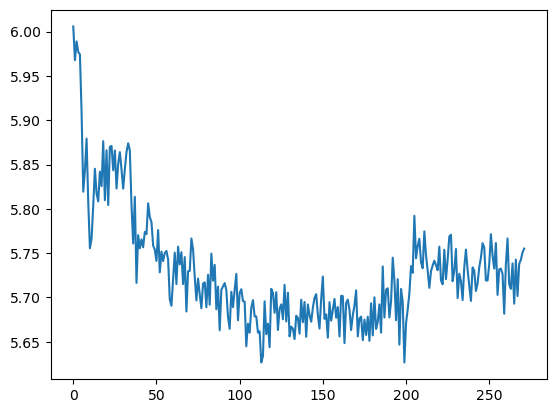

Best combination: Variables [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200] with RMSE 5.6267
{'best_combination': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 1

In [17]:
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold
from sklearn.metrics import root_mean_squared_error
from sklearn.ensemble import RandomForestRegressor  # Example model
from xgboost import XGBRegressor  # Alternate model
# explicitly require this experimental feature
from sklearn.experimental import enable_halving_search_cv # noqa
# now you can import normally from model_selection
from sklearn.model_selection import HalvingGridSearchCV


#def find_best_meteorological_variables(X_vars, Y, folds=5, model_type=RandomForestRegressor, model_params=None):
"""
Find the best combination of meteorological variables to predict the target.

Args:
    X_vars (list of numpy.ndarray): List of input arrays for each variable, shape (n_i, m).
    Y (numpy.ndarray): Output data, shape (m, 15).
    folds (int): Number of folds for cross-validation.
    model_type: The model class to use.
    model_params (dict): Parameters for initializing the model.

Returns:
    dict: Dictionary with the best combination of variables and the corresponding RMSE.
"""
X_vars = all_input
Y = u_gust
folds = 7
model_type = RandomForestRegressor
model_params = {}#{'n_jobs':-1}

n_vars = len(X_vars)
best_rmse = float('inf')
best_combination = None
rmse_scores_per_combination = []

for num_vars in range(1, n_vars + 1):  # Add variables one at a time

    combined_X = np.concatenate(X_vars[:num_vars], axis=0)  # Combine first `num_vars` variables
    print(f"Testing with {num_vars} variables...")

    kf = KFold(n_splits=folds, shuffle=True, random_state=42)
    rmse_scores = []

    storm_index = combined_X[0, :].astype(int)

    # Remove test storms

    _, test_storms, _ = extraction_squares.split_storm_numbers(storm_index, 0.12, 'number', 42)
    storm_index = storm_index[~np.isin(storm_index, test_storms)]

    for train_index, val_index in kf.split(storm_index):  # Transpose X for (m, features)
        X_train, X_val = combined_X[:, train_index], combined_X[:, val_index]
        train_index, val_index = storm_index[train_index], storm_index[val_index]
        Y_train, Y_val = Y[Y['storm_number'].isin(train_index)], Y[Y['storm_number'].isin(val_index)]

        # drop the storm_number column
        Y_train = Y_train.drop(columns=['storm_number'])
        Y_val = Y_val.drop(columns=['storm_number'])
        # drop the first row of X_train and X_val
        X_train = X_train[1:, :]
        X_val = X_val[1:, :]

        model = model_type(random_state = 42, n_jobs = -1)#**(model_params or {}))
        model.fit(X_train.T, Y_train)  # Transpose back to (m_train, features)
        Y_pred = model.predict(X_val.T)

        # RMSE Calculation
        rmse_bef = root_mean_squared_error(Y_val, Y_pred)

        # # Hypertuning
        # if model_type == RandomForestRegressor:
        #     param_grid_mod = {
        #         'n_estimators': [5, 10, 20, 50, 100, 200, 500],
        #         'max_depth': [1, 2, 3, 5, 10, 20, 40]
        #     }
        # else:
        #     param_grid_mod = model_params

        # search = HalvingGridSearchCV(model, param_grid_mod, cv=2, n_jobs=-1, verbose=0)
        # search.fit(X_train.T, Y_train)

        # # Get best model after tuning
        # best_model = search.best_estimator_
        # Y_pred = best_model.predict(X_val.T)

        # rmse_aft = root_mean_squared_error(Y_val, Y_pred)

        # if rmse_aft < rmse_bef:
        #     rmse_scores.append(rmse_aft)
        # else:
        rmse_scores.append(rmse_bef)

    avg_rmse = np.mean(rmse_scores)
    rmse_scores_per_combination.append(avg_rmse)
    print(f"Average RMSE with {num_vars} variables: {np.round(avg_rmse, 4)}")

    if avg_rmse < best_rmse:
        best_rmse = avg_rmse
        best_combination = list(range(1, num_vars + 1))

plt.plot(rmse_scores_per_combination)
plt.show()

print(f"Best combination: Variables {best_combination} with RMSE {np.round(best_rmse, 4)}")
print( {
    "best_combination": best_combination,
    "best_rmse": np.round(best_rmse, 4),
    "all_rmse": rmse_scores_per_combination,
})